#Q1

Gaussian Processes (GPs) is is a specific type of stochastic process where any finite collection of random variables has a joint Gaussian distribution. In simpler terms, a Gaussian process is described by a mean function m(x) and a covariance function k(x, x') which together define the distribution of functions over a domain.

Given a set of input points x1.....xn, the corresponding function values f(x1)....f(xn) are jointly distributed as a multivariate normal. The Gaussian Process is specified as:

                                        f(x)~ GP(m(x), k(x, x'))
Stochastic process is a collection of random variables indexed by time or space. They are used to model systems that evolve over time in a probabilistic manner. Examples include Brownian motion, Markov processes, and Poisson processes. Stochastic processes can model a wide variety of real-world phenomena, from stock prices to physical systems.

Variational Inference is an approximate Bayesian inference technique used when computing the posterior distribution is computationally intractable. The core idea is to approximate the true posterior p(\theta \|x) with a simpler distribution q(\theta \). This is done by minimizing the Kullback-Leibler (KL) divergence between the approximating distribution q(\theta \) and the true posterior.

The KL divergence formulation is given as:

![](hw101.png)

where p(x) is the marginal likelihood (or evidence), and the ELBO represents a lower bound on the log marginal likelihood.

The ELBO is the key quantity used in variational inference to optimize the variational distribution. The ELBO is expressed as:

![](hw102.png)

Maximizing the ELBO is equivalent to maximizing the marginal likelihood p(x) while regularizing the model by minimizing the KL divergence between the variational distribution and the true posterior. This allows us to obtain an efficient approximation to the true posterior distribution.

/opt/conda/lib/python3.11/site-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ℓ, η, σ]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 13 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [f_pred]


ValueError: x and y must have same first dimension, but have shapes (100,) and (500, 100)

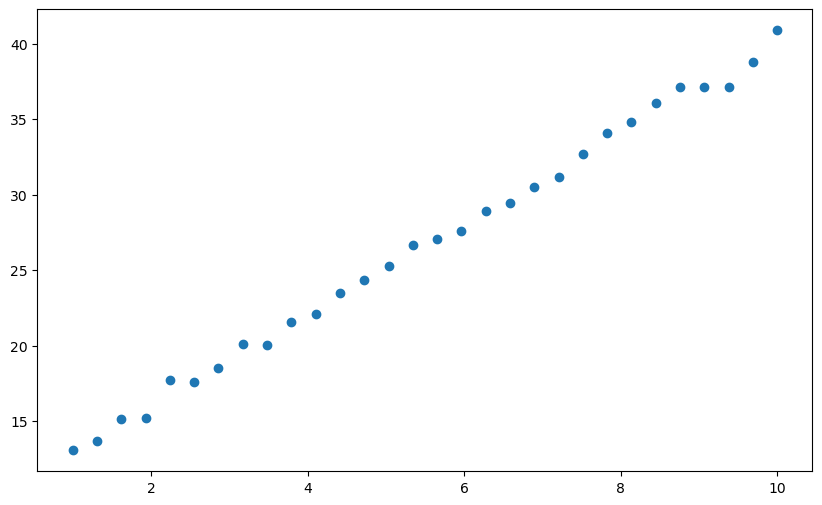

In [9]:
#Q2

import pymc as pm
import numpy as np
import matplotlib.pyplot as plt

seed = 1008111151
np.random.seed(seed)

X = np.linspace(1, 10, 30)[:, None]  # 1 to 10 rooms
y = 3 * X.ravel() + 10 + 0.5 * np.random.randn(30)  # Linear relationship with noise

with pm.Model() as gp_model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfNormal("η", sigma=1)
    cov_func = η**2 * pm.gp.cov.ExpQuad(1, ℓ)
    
    gp = pm.gp.Marginal(cov_func=cov_func)
    σ = pm.HalfNormal("σ", sigma=0.5)
    
    y_obs = gp.marginal_likelihood("y_obs", X=X, y=y, noise=σ)
    
    trace = pm.sample(500, chains=1, random_seed=seed)

    X_new = np.linspace(0, 12, 100)[:, None]
    
    f_pred = gp.conditional("f_pred", X_new)
    
    # Generate posterior predictive samples
    pp_samples = pm.sample_posterior_predictive(
        trace, 
        var_names=["f_pred"],
        predictions=True,
        random_seed=seed
    )

if "predictions" in pp_samples:
    predictions = pp_samples["predictions"]["f_pred"]
else:
    predictions = pp_samples["f_pred"]

pred_mean = predictions.mean(axis=0)
pred_quantiles = np.percentile(predictions, [2.5, 97.5], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(X, y, "o", label="Observed data")
plt.plot(X_new.ravel(), pred_mean, label="Posterior mean")
plt.fill_between(
    X_new.ravel(),
    pred_quantiles[0],
    pred_quantiles[1],
    alpha=0.3,
    label="95% CI"
)
plt.legend()
plt.xlabel("Number of Rooms")
plt.ylabel("House Price")
plt.title("Gaussian Process Regression")
plt.show()





Finished [100%]: Average Loss = 6.9435e+06


ValueError: x and y can be no greater than 2D, but have shapes (100, 1) and (100, 1, 1, 1)

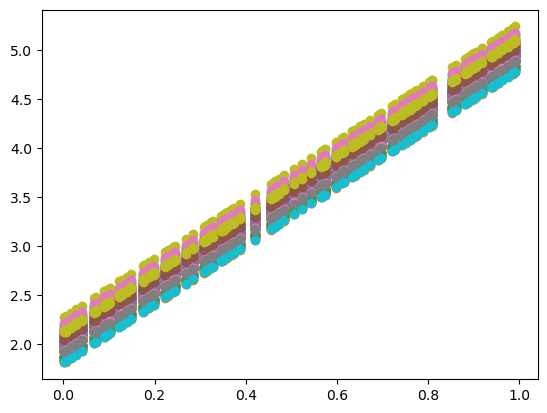

In [10]:
#Q3

import pymc as pm
import numpy as np
import matplotlib.pyplot as plt

X = np.random.rand(100, 1)
y = 3 * X + 2 + 0.1 * np.random.randn(100)  

with pm.Model() as neural_net:
    n_hidden = 5  
    W1 = pm.Normal('W1', mu=0, sigma=1, shape=(1, n_hidden))
    b1 = pm.Normal('b1', mu=0, sigma=1, shape=(n_hidden,))
    W2 = pm.Normal('W2', mu=0, sigma=1, shape=(n_hidden, 1))
    b2 = pm.Normal('b2', mu=0, sigma=1, shape=(1,))

    hidden = pm.math.tanh(pm.math.dot(X, W1) + b1)
    output = pm.math.dot(hidden, W2) + b2

    likelihood = pm.Normal('y', mu=output, sigma=0.1, observed=y)

    approx = pm.fit(1000, method='advi', random_seed=1008111151)

trace = approx.sample(500)

posterior_samples = trace.posterior

W1_mean = posterior_samples['W1'].mean(dim='draw').values
b1_mean = posterior_samples['b1'].mean(dim='draw').values
W2_mean = posterior_samples['W2'].mean(dim='draw').values
b2_mean = posterior_samples['b2'].mean(dim='draw').values

hidden_layer = np.tanh(np.dot(X, W1_mean) + b1_mean)
y_pred = np.dot(hidden_layer, W2_mean) + b2_mean

plt.plot(X, y, 'o', label='Observed Data')
plt.plot(X, y_pred, label='Fitted Model')
plt.xlabel("Input")
plt.ylabel("Output")
plt.legend()
plt.show()




